In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Tensorflow 및 기타 라이브러리 가져오기

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.1.0


# 데이터 불러오기

In [4]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data_3000.zip to data_3000.zip
User uploaded file "data_3000.zip" with length 3309996 bytes


In [0]:
! mkdir data_3000
! unzip data_3000.zip -d ./data_3000

In [17]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_3000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다. 
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 

X,Y = [],[]
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기 
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


# (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_shape:{}  Data_shape:{}".format(np.shape(x_train),np.shape(x_train[0])))

Datasets_shape:(2400, 3136)  Data_shape:(3136,)


# Autoencoder 모델 만들기

In [0]:
#Hyperparameters
image_size = np.shape(x_train[0])[0]
mid_dim = 512
h_dim = 20
num_epochs = 100
batch_size = 64
learning_rate = 1e-3

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3136)]            0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1606144   
_________________________________________________________________
dense_29 (Dense)             (None, 20)                10260     
_________________________________________________________________
dense_30 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_31 (Dense)             (None, 3136)              1608768   
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
_________________________________________________________________


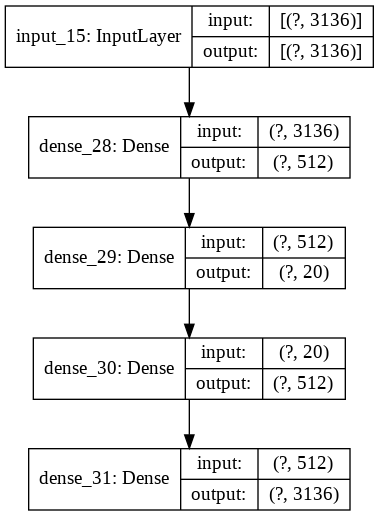

In [55]:
input_img = tf.keras.layers.Input(shape=(image_size,))

#인코더 정의
encoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(input_img)
encoded = tf.keras.layers.Dense(h_dim, activation='relu')(encoded)

#디코더 정의
decoded = tf.keras.layers.Dense(mid_dim,activation = 'relu')(encoded)
decoded = tf.keras.layers.Dense(image_size, activation='sigmoid')(decoded)

#AE 정의
autoencoder = Model(input_img,decoded)

#AE 학습 loss, optimizer 정의
autoencoder.compile(optimizer='adam', loss='mse')

#AE 네트워크 확인
autoencoder.summary()
plot_model(autoencoder, to_file='ae.png', show_shapes=True)

In [0]:
# 모델학습 
autoencoder.fit(x_train, x_train,
                nb_epoch=num_epochs, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test, x_test))

# 학습된 모델로 데이터 복원하기

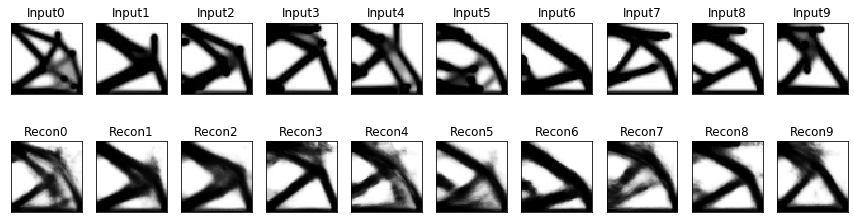

In [54]:
recon_x_test =autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()